# HDTree example Notebook

## Setup

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from typing import Tuple
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib
from mlxtend.plotting import plot_decision_regions
import graphviz
from hdtree import HDTreeClassifier, EntropyMeasure, SmallerThanSplit, TwentyQuantileSplit, TwentyQuantileRangeSplit, SingleCategorySplit, FixedValueSplit
import pandas as pd
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
blue = "#2a6bb7"
orange = "#E97817"

# Generate x * log(x) plot
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 13}

matplotlib.rc('font', **font)
standard_cmap = 'pastell'
sns.set_style("whitegrid")

## A problem with decision boundaries...

In [4]:
def generate_example_data() -> Tuple[np.ndarray, np.ndarray]:
    
    def shift(x, y):
        # shift data a bit away from the street
        street_size = .75
        if abs(x-y) < street_size: # almost on boundary
            if x < y:
                x-=street_size
                y+=street_size
            else:
                y-=street_size
                x+=street_size
                
        return [x,y]

    # generate normal distributed data 
    np.random.seed(1)
    x_data_decision_tree = np.array([[np.random.rand(1)[0]*10-5+np.random.normal(scale=2), 
                                      np.random.rand(1)[0]*10-5+np.random.normal(scale=2)] for x in range(3000)])
    
    # free the street in the middle
    x_data_decision_tree = np.array([*map(lambda xy: shift(*xy), x_data_decision_tree)])
    
    # label it positive an negative respectively
    y_data_decision_tree = np.array([*map(lambda pos: 1 if pos[0] < pos[1] else 0, x_data_decision_tree)])
    
    # change some labels randomly
    y_data_decision_tree = np.array(
        [cls if np.random.rand() < 0.95 else (1 if cls == 0 else 0) for cls in y_data_decision_tree])
    
    return x_data_decision_tree, y_data_decision_tree

In [5]:
# generate data
X_street, y_street = generate_example_data()
X_street_train, X_street_test, y_street_train, y_street_test = train_test_split(X_street, y_street, test_size=.33)

In [6]:
# train some decision trees
tree_4 = DecisionTreeClassifier(max_depth=4)
tree_8 = DecisionTreeClassifier(max_depth=8)
tree_16 = DecisionTreeClassifier(max_depth=16)

tree_4.fit(X_street_train, y_street_train)
tree_8.fit(X_street_train, y_street_train)
tree_16.fit(X_street_train, y_street_train)

trees = [tree_4, tree_8, tree_16]

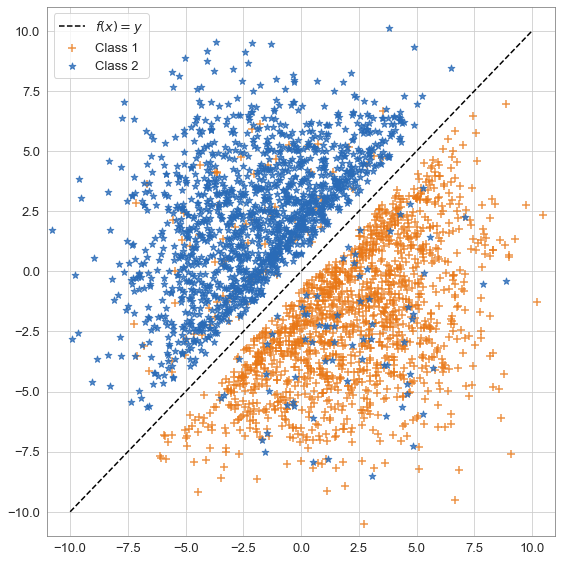

In [7]:
# plot the two class problem as is
fig, ax = plt.subplots(1,1, figsize=(8,8))
class_0 = X_street[y_street==0]
class_1 = X_street[y_street==1]
    
plt.scatter(class_0[:, 0], class_0[:,1], c=orange, marker='+', s=70, alpha=0.8)
plt.scatter(class_1[:, 0], class_1[:,1], c=blue,   marker='*', s=50, alpha=0.8)
regressor_line = plt.plot([-10, 10], [-10, 10], linestyle='--', c='black')
_ = plt.legend(['$f(x)=y$', 'Class 1', 'Class 2'])
        
ax = plt.gca()
plt.gca().set_xlim([-11, 11])
plt.gca().set_ylim([-11, 11])
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
plt.tight_layout()

# plt.savefig("linear.png", bbbox_inches=0)

C:\Users\Richard\Anaconda3\envs\gonviz\lib\site-packages\mlxtend\plotting\decision_regions.py:249: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())
C:\Users\Richard\Anaconda3\envs\gonviz\lib\site-packages\mlxtend\plotting\decision_regions.py:249: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())
C:\Users\Richard\Anaconda3\envs\gonviz\lib\site-packages\mlxtend\plotting\decision_regions.py:249: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


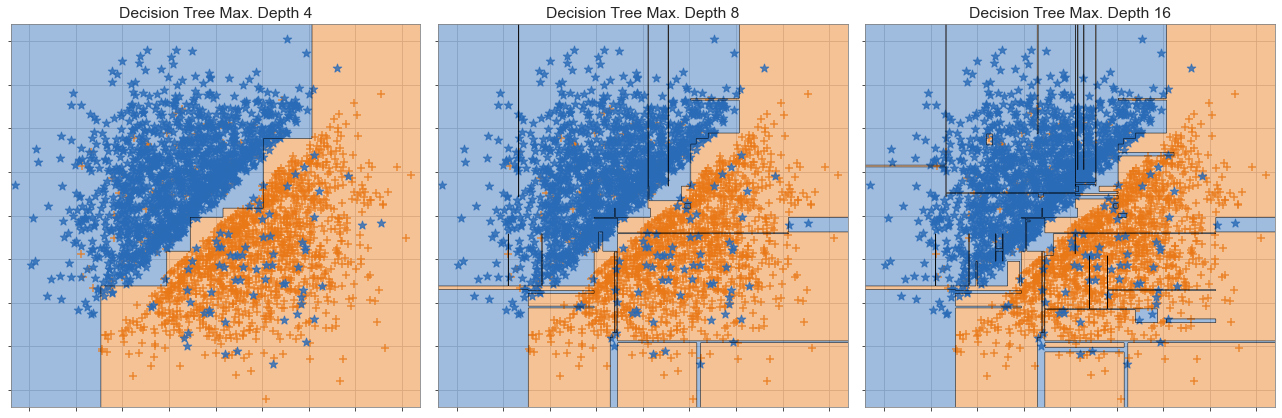

In [8]:
# plot the Decision bounaries of the decision trees
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
titles = ["Decision Tree Max. Depth 4", "Decision Tree Max. Depth 8", "Decision Tree Max. Depth 16"]
for i in range(0,3):
    plt.sca(axs[i])
    plot_decision_regions(X_street,
                          y_street,
                          clf=trees[i], 
                          markers='+*',
                          colors=','.join([orange, blue]), 
                          ax=plt.gca(), 
                          legend=0,
                          scatter_kwargs={'s': 80, 'edgecolor': None}, 
                          hide_spines=False)
    
    ax = plt.gca()

    plt.setp(ax.get_yticklabels(), visible=False)
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.title(titles[i])

    plt.gca().set_xlim([-11, 11])
    plt.gca().set_ylim([-11, 11])
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color('0.5')
    ax.spines['right'].set_color('0.5')
    ax.spines['left'].set_color('0.5')
    
plt.tight_layout()

# plt.savefig("tree_decision_region.png", bbbox_inches=0)

In [9]:
graph = graphviz.Source(export_graphviz(tree_4, class_names=["Class 1", "Class 2"], 
                                        feature_names=['x', 'y'], filled=True))

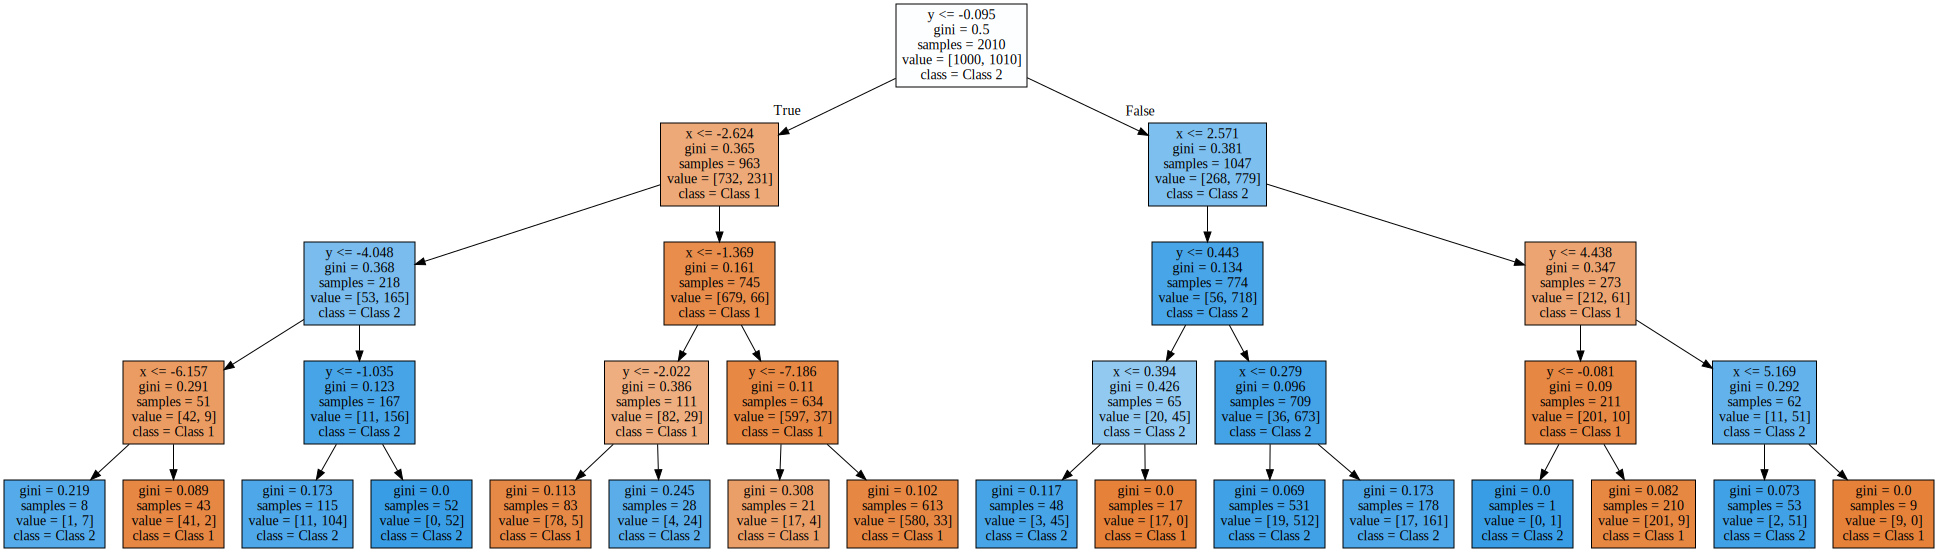

In [10]:
graph

In [11]:
# graph.render("dt4.png", format='png', )

'dt4.png.png'

In [12]:
for tree in trees:
    print(tree.score(X_street_test, y_street_test), tree.score(X_street_train, y_street_train))

0.9383838383838384 0.945273631840796
0.9303030303030303 0.9656716417910448
0.908080808080808 0.9880597014925373


## HDTree examples

In [13]:
from hdtree import HDTreeClassifier, SmallerThanSplit, EntropyMeasure

In [16]:
hdtree_linear = HDTreeClassifier(allowed_splits=[SmallerThanSplit.build()], 
                                 information_measure=EntropyMeasure(),
                                 attribute_names=['x', 'y'])

In [22]:
hdtree_linear.fit(X_street_train, y_street_train)

In [25]:
hdtree_linear.score(X_street_test, y_street_test)

0.9515151515151515

In [31]:
# hdtree_linear.generate_dot_graph().render('linear_tree', format='png')

'linear_tree.png'

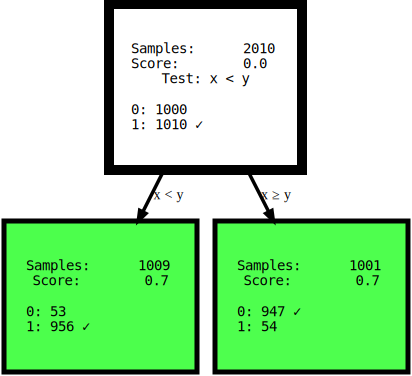

In [32]:
hdtree_linear.generate_dot_graph()

## Titanic

In [32]:
df_titanic = pd.read_csv("data/titanic.csv")

In [33]:
df_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [34]:
df_titanic['Name Length'] = df_titanic['Name'].map(lambda name: len(name))
y_titanic = df_titanic['Survived'].map(lambda s: 'Survived' if s == 1 else 'Death')

In [35]:
del df_titanic['Name']
del df_titanic['Ticket']
del df_titanic['Survived']

In [36]:
df_titanic['Survived'] = y_titanic

In [37]:
df_titanic.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Name Length,Survived
0,1,3,male,22.0,1,0,7.2500,NaN,S,23,Death
1,2,1,female,38.0,1,0,71.2833,C85,C,51,Survived
2,3,3,female,26.0,0,0,7.9250,NaN,S,22,Survived
3,4,1,female,35.0,1,0,53.1000,C123,S,44,Survived
4,5,3,male,35.0,0,0,8.0500,NaN,S,24,Death


In [38]:
X_titanic_train, X_titanic_test, y_titanic_train, y_titanic_test = train_test_split(df_titanic.iloc[:,:-1], 
                                                                                    df_titanic.iloc[:,-1], test_size=0.33, 
                                                                                    random_state=42)

In [39]:
col_names = [*df_titanic.columns[:-1]]

In [62]:
hdtree_titanic = HDTreeClassifier(allowed_splits=[FixedValueSplit.build(), SingleCategorySplit.build(), TwentyQuantileRangeSplit.build(), TwentyQuantileSplit.build()], information_measure=EntropyMeasure(), attribute_names=col_names, max_levels=3)

In [63]:
hdtree_titanic.fit(X_titanic_train.values, y_titanic_train.values)

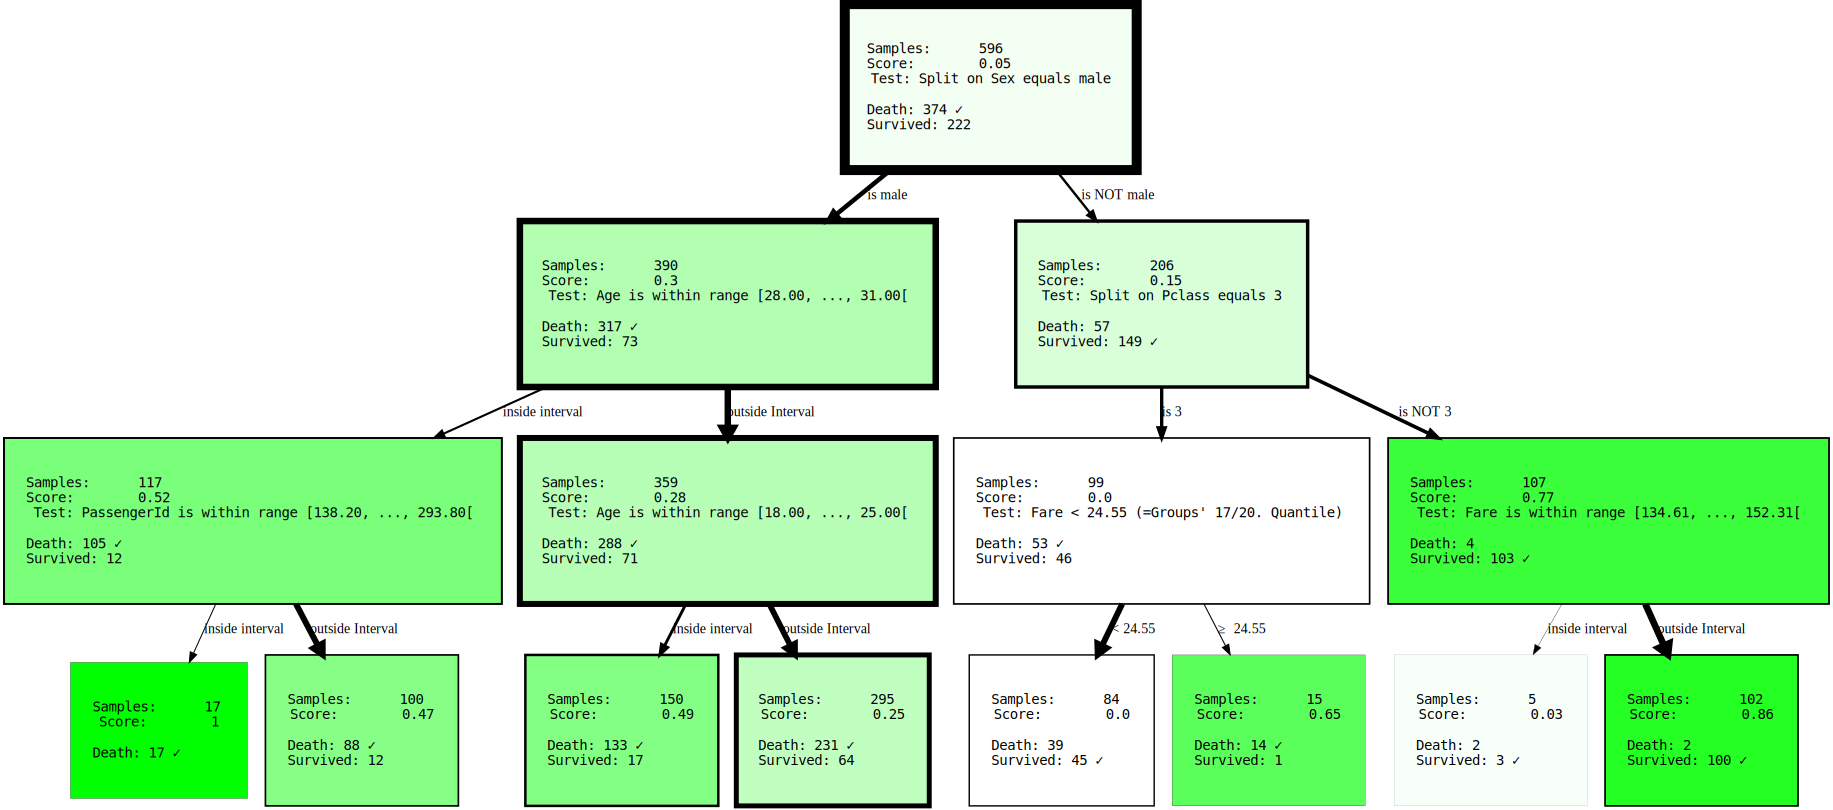

In [64]:
hdtree_titanic.generate_dot_graph()

In [65]:
hdtree_titanic.score(X_titanic_train.values, y_titanic_train), hdtree_titanic.score(X_titanic_test.values, y_titanic_test)

(0.8036912751677853, 0.8169491525423729)

In [67]:
# hdtree_titanic.generate_dot_graph().render('hd_tree_titanic_1', format='png')

'hd_tree_titanic_1.png'

In [71]:
hdtree_titanic_2 = HDTreeClassifier(allowed_splits=[FixedValueSplit.build_with_restrictions(min_level=1), SingleCategorySplit.build_with_restrictions(min_level=1), TwentyQuantileRangeSplit.build(), TwentyQuantileSplit.build()], information_measure=EntropyMeasure(), attribute_names=col_names, max_levels=3)
hdtree_titanic_2.fit(X_titanic_train.values, y_titanic_train.values)

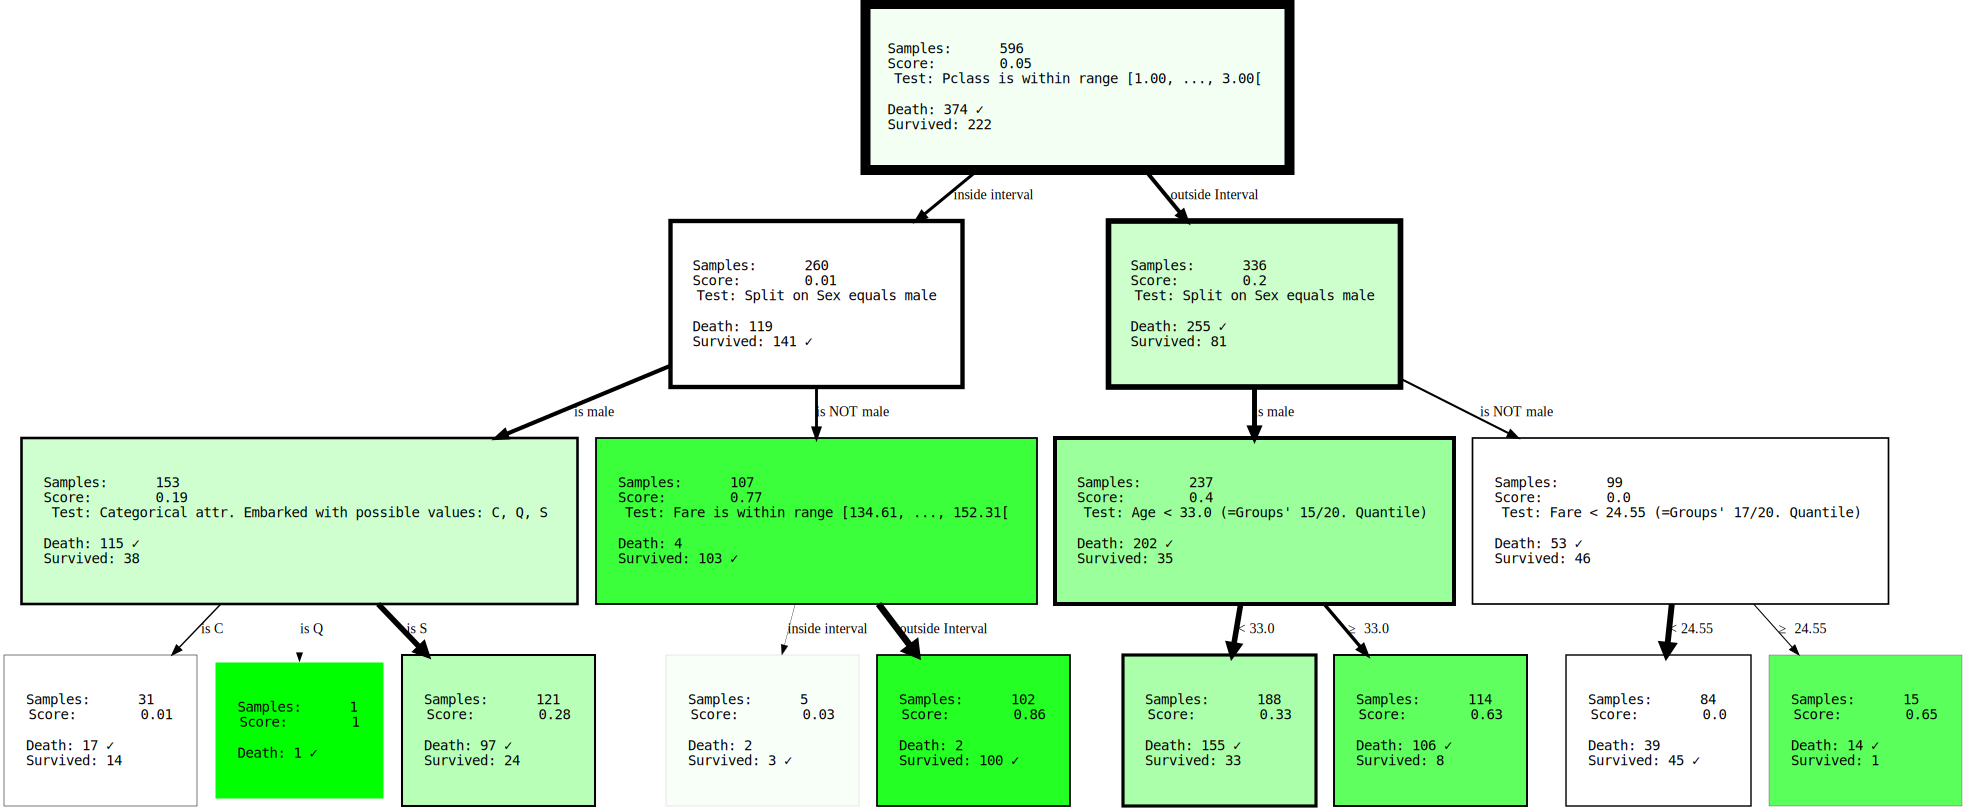

In [72]:
hdtree_titanic_2.generate_dot_graph()

In [75]:
hdtree_titanic_2.score(X_titanic_train.values, y_titanic_train), hdtree_titanic_2.score(X_titanic_test.values, y_titanic_test)

(0.8036912751677853, 0.8169491525423729)

In [74]:
hdtree_titanic_2.generate_dot_graph().render('hd_tree_titanic_2', format='png')

'hd_tree_titanic_2.png'

In [89]:
hdtree_titanic_3 = HDTreeClassifier(allowed_splits=[FixedValueSplit.build_with_restrictions(blacklist_attribute_indices=['Name Length']), SingleCategorySplit.build(), TwentyQuantileRangeSplit.build_with_restrictions(blacklist_attribute_indices=['PassengerId']), TwentyQuantileSplit.build()], information_measure=EntropyMeasure(), attribute_names=col_names, max_levels=3)
hdtree_titanic_3.fit(X_titanic_train.values, y_titanic_train.values)

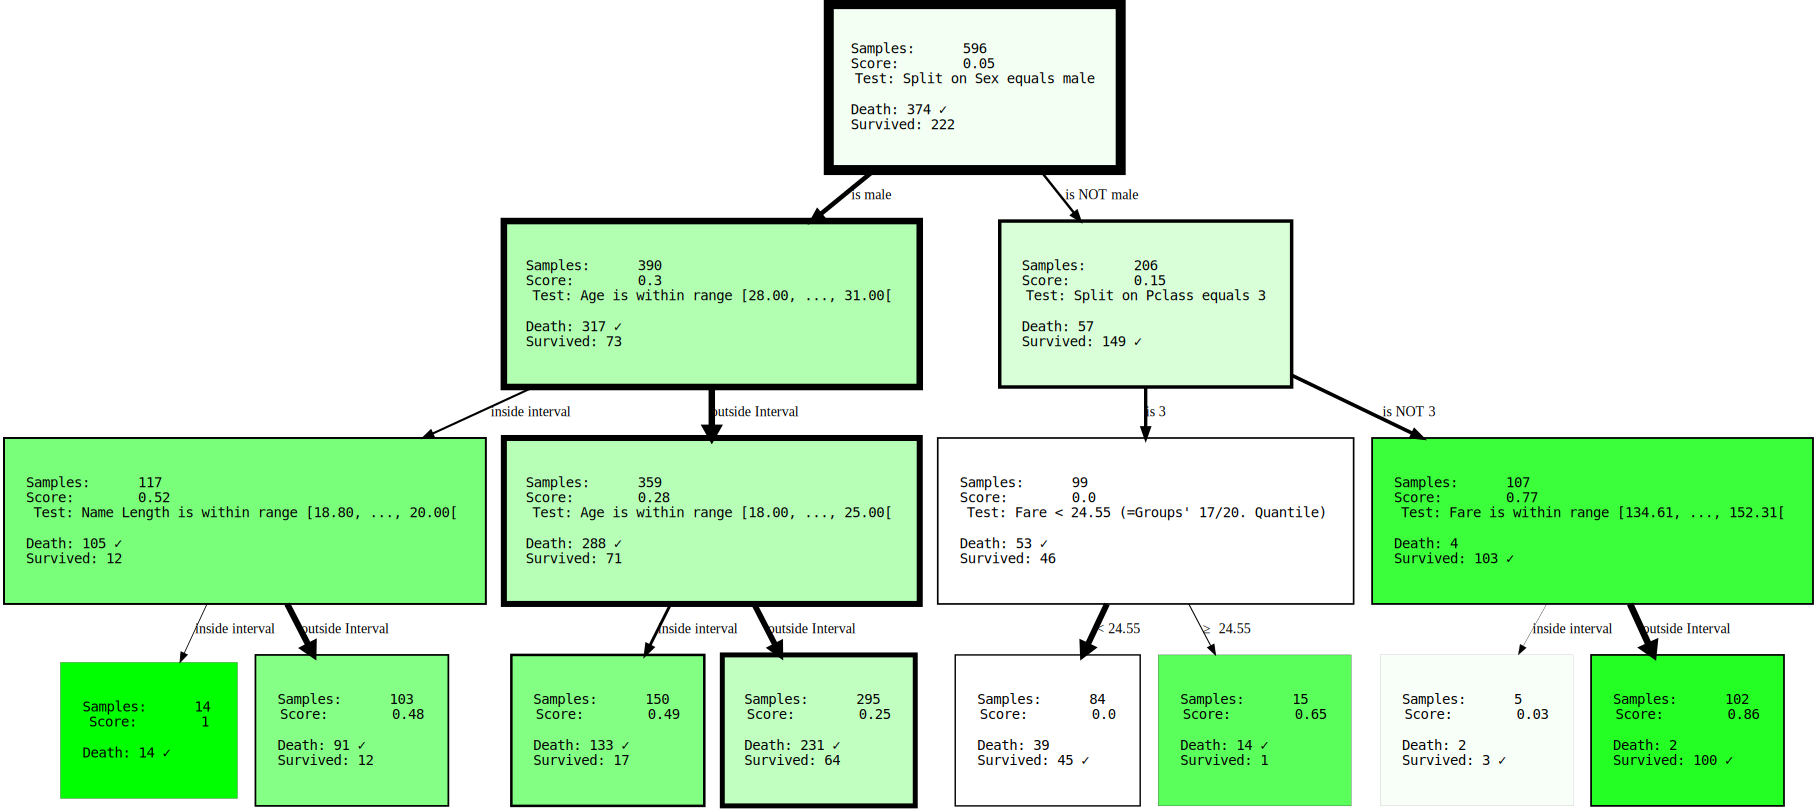

In [90]:
hdtree_titanic_3.generate_dot_graph()

In [88]:
hdtree_titanic_3.score(X_titanic_train.values, y_titanic_train), hdtree_titanic_3.score(X_titanic_test.values, y_titanic_test)

(0.8238255033557047, 0.8135593220338984)

In [94]:
print(hdtree_titanic_3.explain_decision(X_titanic_train.values[42]))

Query: 
 {'PassengerId': 273, 'Pclass': 2, 'Sex': 'female', 'Age': 41.0, 'SibSp': 0, 'Parch': 1, 'Fare': 19.5, 'Cabin': nan, 'Embarked': 'S', 'Name Length': 41}

Predicted sample as "Survived" because of: 
Explanation 1:
Step 1: Sex doesn't match value male
Step 2: Pclass doesn't match value 3
Step 3: Fare is OUTSIDE range [134.61, ..., 152.31[(19.50 is below range)
Step 4: Leaf. Vote for {'Survived'}
---------------------------------



In [96]:
passenger_42 = X_titanic_train.values[42].copy()
passenger_42[2] = None
print(hdtree_titanic_3.explain_decision(passenger_42))

Query: 
 {'PassengerId': 273, 'Pclass': 2, 'Sex': None, 'Age': 41.0, 'SibSp': 0, 'Parch': 1, 'Fare': 19.5, 'Cabin': nan, 'Embarked': 'S', 'Name Length': 41}

Predicted sample as "Death" because of: 
Explanation 1:
Step 1: Sex has no value available
Step 2: Age is OUTSIDE range [28.00, ..., 31.00[(41.00 is above range)
Step 3: Age is OUTSIDE range [18.00, ..., 25.00[(41.00 is above range)
Step 4: Leaf. Vote for {'Death'}
---------------------------------
Explanation 2:
Step 1: Sex has no value available
Step 2: Pclass doesn't match value 3
Step 3: Fare is OUTSIDE range [134.61, ..., 152.31[(19.50 is below range)
Step 4: Leaf. Vote for {'Survived'}
---------------------------------



In [97]:
print(hdtree_titanic_3)

Level 0, ROOT: Node having 596 samples and 2 children with split rule "Split on Sex equals male" (Split Score: 0.251)
-Level 1, Child #1: Node having 390 samples and 2 children with split rule "Age is within range [28.00, ..., 31.00[" (Split Score: 0.342)
--Level 2, Child #1: Node having 117 samples and 2 children with split rule "Name Length is within range [18.80, ..., 20.00[" (Split Score: 0.543)
---Level 3, Child #1: Node having 14 samples and no children with split rule "no split rule" (Node Score: 1) (LEAF)
---Level 3, Child #2: Node having 103 samples and no children with split rule "no split rule" (Node Score: 0.481) (LEAF)
--Level 2, Child #2: Node having 359 samples and 2 children with split rule "Age is within range [18.00, ..., 25.00[" (Split Score: 0.328)
---Level 3, Child #1: Node having 150 samples and no children with split rule "no split rule" (Node Score: 0.49) (LEAF)
---Level 3, Child #2: Node having 295 samples and no children with split rule "no split rule" (Node S

In [104]:
[str(node) for node in hdtree_titanic_3.get_clean_nodes(min_score=0.5)]

['Node having 117 samples and 2 children with split rule "Name Length is within range [18.80, ..., 20.00[" (Split Score: 0.543)',
 'Node having 14 samples and no children with split rule "no split rule" (Node Score: 1)',
 'Node having 15 samples and no children with split rule "no split rule" (Node Score: 0.647)',
 'Node having 107 samples and 2 children with split rule "Fare is within range [134.61, ..., 152.31[" (Split Score: 0.822)',
 'Node having 102 samples and no children with split rule "no split rule" (Node Score: 0.861)']